In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA

import skops.io as sio

import numpy as np

c:\Users\matte\miniconda3\envs\sciEnv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\matte\miniconda3\envs\sciEnv\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\matte\miniconda3\envs\sciEnv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\matte\miniconda3\envs\sciEnv\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def get_esposizione(s=''):

    _l = ['ovest', 'nord', 'sud', 'est']
    _o = {i:0 for i in _l}

    for c in _l:

        if c in s:

            _o[c] = 1
            s = s.replace(c, '')

    return _o 

In [3]:
data = pd.read_excel('output_data_1k.xlsx')

In [4]:
bologna_shp = gpd.read_file('./shapefile/aree-statistiche.geojson')

In [5]:
def get_geo_info(p, shp):

    _ = shp.loc[shp.geometry.apply(lambda x: x.contains(p)), ['codice_area_statistica', 'area_statistica', 'cod_quar', 'quartiere', 'cod_zona', 'zona']]
    
    if _.shape[0] == 0:
        
        _row = {i:'ND' for i in _.columns}
        _ = _.append(_row, ignore_index=True)
        
    return _



In [6]:
data['P'] = data[['longitudine', 'latitudine']].apply(lambda x: Point(x['longitudine'], x['latitudine']), axis=1)

In [7]:
geo_enr = data.P.apply(lambda x: get_geo_info(x,bologna_shp)).to_list()
geo_enr_pdf = pd.concat(geo_enr)
geo_enr_pdf.index = data.index


C:\Users\matte\AppData\Local\Temp\ipykernel_10140\1538752299.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _ = _.append(_row, ignore_index=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_10140\1538752299.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _ = _.append(_row, ignore_index=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_10140\1538752299.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _ = _.append(_row, ignore_index=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_10140\1538752299.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _ = _.append(_row, ignore_index=True)
C:\Users\matte\AppData\Local\Temp\ipyker

In [8]:
data_bak = data.copy()

In [9]:
#data = data_bak

In [10]:
data = data.join(geo_enr_pdf)
data = data.loc[~data.euro_mq.isna()]
data = data.loc[(data.prezzo.between(80_000, 2_000_000)) & (data.superficie.between(20, 500)) & (data.euro_mq.between(1_000, 5_000))]
data.set_index('id_ann', inplace=True)

In [11]:
data['round_lat'] = data.latitudine.round(2)
data['round_lng'] = data.longitudine.round(2)

In [12]:
data['zona_adj'] = data[['zona', 'cod_zona', 'area_statistica']].apply(lambda x: x['zona'] +'_'+ x['area_statistica'] if x['zona'] in ['San Donato', 'Lame'] else x['zona'], axis=1)

In [13]:
target = ['euro_mq']
features = [i for i in data.columns if i.endswith('_ac_feat')]
features = features + ['ascensore','climatizzato','round_lat','round_lng']
model_data = data.loc[:, ['data_prima_presenza_online', 'superficie', 'prezzo', 'url_ann'] + features + target]

In [14]:
oh_stato = OneHotEncoder(sparse=False)
oh_stato.fit(data[['stato']])
stato_pdf = pd.DataFrame(oh_stato.transform(data[['stato']]), columns=oh_stato.get_feature_names_out(), index=data.index)
stato_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,stato_Buono / Abitabile,stato_Da ristrutturare,stato_Non partecipabile,stato_Nuovo / In costruzione,stato_Ottimo / Ristrutturato,stato_Partecipabile,stato_nan
id_ann,,,,,,,
5995,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6002,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6005,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6011,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
sio.dump(oh_stato, 'model/one_hot/stato.skops')

In [16]:
oh_locali = OneHotEncoder(sparse=False)
oh_locali.fit(data[['locali']])
locali_pdf = pd.DataFrame(oh_locali.transform(data[['locali']]), columns=oh_locali.get_feature_names_out(), index=data.index)
locali_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,locali_0,locali_1,locali_2,locali_3,locali_4,locali_5,locali_5+,locali_nan
id_ann,,,,,,,,
5995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6011,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
sio.dump(oh_locali, 'model/one_hot/locali.skops')

In [18]:
oh_bagni = OneHotEncoder(sparse=False)
oh_bagni.fit(data[['bagni_lkp']])
bagni_pdf = pd.DataFrame(oh_bagni.transform(data[['bagni_lkp']]), columns=oh_bagni.get_feature_names_out(), index=data.index)
bagni_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,bagni_lkp_##,bagni_lkp_00,bagni_lkp_01,bagni_lkp_02,bagni_lkp_03,bagni_lkp_3+
id_ann,,,,,,
5995,0.0,0.0,0.0,1.0,0.0,0.0
6002,0.0,0.0,1.0,0.0,0.0,0.0
6005,0.0,0.0,1.0,0.0,0.0,0.0
6011,0.0,0.0,1.0,0.0,0.0,0.0
6013,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
sio.dump(oh_bagni, 'model/one_hot/bagni.skops')

In [20]:
oh_p_totali = OneHotEncoder(sparse=False)
oh_p_totali.fit(data[['piani_totali_lkp']])
p_totali_pdf = pd.DataFrame(oh_p_totali.transform(data[['piani_totali_lkp']]), columns=oh_p_totali.get_feature_names_out(), index=data.index)
p_totali_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,piani_totali_lkp_-1,piani_totali_lkp_01,piani_totali_lkp_02,piani_totali_lkp_03,piani_totali_lkp_04,piani_totali_lkp_05,piani_totali_lkp_06,piani_totali_lkp_07,piani_totali_lkp_08,piani_totali_lkp_09,piani_totali_lkp_10,piani_totali_lkp_10+
id_ann,,,,,,,,,,,,
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
sio.dump(oh_p_totali, 'model/one_hot/piani_totali.skops')

In [22]:
oh_piano = OneHotEncoder(sparse=False)
oh_piano.fit(data[['piano_lkp']])
piano_pdf = pd.DataFrame(oh_piano.transform(data[['piano_lkp']]), columns=oh_piano.get_feature_names_out(), index=data.index)
piano_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,piano_lkp_ A,piano_lkp_ R,piano_lkp_ S,piano_lkp_ T,piano_lkp_+0,piano_lkp_00,piano_lkp_01,piano_lkp_02,piano_lkp_03,piano_lkp_04,...,piano_lkp_06,piano_lkp_07,piano_lkp_08,piano_lkp_09,piano_lkp_10,piano_lkp_10+,piano_lkp_S2,piano_lkp_S3,piano_lkp_S4,piano_lkp_S5
id_ann,,,,,,,,,,,,,,,,,,,,,
5995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6011,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
sio.dump(oh_piano, 'model/one_hot/piano.skops')

In [24]:
oh_zona = OneHotEncoder(sparse=False)
oh_zona.fit(data[['zona_adj']])
zona_pdf = pd.DataFrame(oh_zona.transform(data[['zona_adj']]), columns=oh_zona.get_feature_names_out(), index=data.index)
zona_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,zona_adj_Barca,zona_adj_Bolognina,zona_adj_Borgo Panigale,zona_adj_Colli,zona_adj_Corticella,zona_adj_Costa Saragozza,zona_adj_Galvani,zona_adj_Irnerio,zona_adj_Lame_BEVERARA,zona_adj_Lame_LA NOCE,...,zona_adj_Saffi,zona_adj_San Donato_CAAB,zona_adj_San Donato_CADRIANO-CALAMOSCO,zona_adj_San Donato_FIERA,zona_adj_San Donato_MICHELINO,zona_adj_San Donato_PILASTRO,zona_adj_San Donato_SAN DONNINO,zona_adj_San Donato_SCALO MERCI SAN DONATO,zona_adj_San Donato_VIA DEL LAVORO,zona_adj_San Donato_VIA MONDO
id_ann,,,,,,,,,,,,,,,,,,,,,
5995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6005,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
sio.dump(oh_zona, 'model/one_hot/zona.skops')

In [26]:
oh_anno_c = OneHotEncoder(sparse=False)
oh_anno_c.fit(data[['anno_costruzione_lkp']])
anno_c_pdf = pd.DataFrame(oh_anno_c.transform(data[['anno_costruzione_lkp']]), columns=oh_anno_c.get_feature_names_out(), index=data.index)
anno_c_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,anno_costruzione_lkp_0_O_ANNO,anno_costruzione_lkp_1_ANTE_1950,anno_costruzione_lkp_3_1950_1960,anno_costruzione_lkp_4_1960_1970,anno_costruzione_lkp_5_1970,anno_costruzione_lkp_6_1970_1990,anno_costruzione_lkp_7_1990_2010,anno_costruzione_lkp_8_POST_2010
id_ann,,,,,,,,
5995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
sio.dump(oh_anno_c, 'model/one_hot/anno_costruzione.skops')

In [28]:
oh_classe_e = OneHotEncoder(sparse=False)
oh_classe_e.fit(data[['classe_energetica_lkp']])
classe_e_pdf = pd.DataFrame(oh_classe_e.transform(data[['classe_energetica_lkp']]), columns=oh_classe_e.get_feature_names_out(), index=data.index)
classe_e_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,classe_energetica_lkp_,classe_energetica_lkp_A,classe_energetica_lkp_B,classe_energetica_lkp_C,classe_energetica_lkp_D,classe_energetica_lkp_E,classe_energetica_lkp_F,classe_energetica_lkp_G
id_ann,,,,,,,,
5995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6002,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
sio.dump(oh_classe_e, 'model/one_hot/classe_energetica.skops')

In [30]:
oh_risc_c = OneHotEncoder(sparse=False)
oh_risc_c.fit(data[['riscaldamento_centralizzato_cat']])
risc_c_pdf = pd.DataFrame(oh_risc_c.transform(data[['riscaldamento_centralizzato_cat']]), columns=oh_risc_c.get_feature_names_out(), index=data.index)
risc_c_pdf.head()

C:\Users\matte\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,riscaldamento_centralizzato_cat_NO,riscaldamento_centralizzato_cat_SI,riscaldamento_centralizzato_cat_nan
id_ann,,,
5995,1.0,0.0,0.0
6002,1.0,0.0,0.0
6005,0.0,1.0,0.0
6011,1.0,0.0,0.0
6013,1.0,0.0,0.0


In [31]:
sio.dump(oh_risc_c, 'model/one_hot/r_centralizzato.skops')

In [32]:
model_data_feat = model_data[features]
model_data_feat = model_data_feat.join(stato_pdf)
model_data_feat = model_data_feat.join(locali_pdf)
model_data_feat = model_data_feat.join(bagni_pdf)
model_data_feat = model_data_feat.join(p_totali_pdf)
model_data_feat = model_data_feat.join(piano_pdf)
model_data_feat = model_data_feat.join(zona_pdf)
model_data_feat = model_data_feat.join(anno_c_pdf)
model_data_feat = model_data_feat.join(classe_e_pdf)
model_data_feat = model_data_feat.join(risc_c_pdf)

model_data_feat = model_data_feat.drop('_ac_feat', axis=1)

model_data_feat.head()

,balcone_ac_feat,cantina_ac_feat,arredato_ac_feat,giardino privato_ac_feat,terrazza_ac_feat,fibra ottica_ac_feat,impianto tv centralizzato_ac_feat,giardino comune_ac_feat,infissi esterni in doppio vetro / pvc_ac_feat,esposizione doppia_ac_feat,...,classe_energetica_lkp_A,classe_energetica_lkp_B,classe_energetica_lkp_C,classe_energetica_lkp_D,classe_energetica_lkp_E,classe_energetica_lkp_F,classe_energetica_lkp_G,riscaldamento_centralizzato_cat_NO,riscaldamento_centralizzato_cat_SI,riscaldamento_centralizzato_cat_nan
id_ann,,,,,,,,,,,,,,,,,,,,,
5995,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6002,1,0,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6005,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6011,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6013,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
f = ['1 balcone_ac_feat','2 balconi_ac_feat','3 balconi_ac_feat','4 balconi_ac_feat']
balconi_n = pd.DataFrame(model_data_feat[f].sum(axis=1), columns=['n'])
balconi_idmax = pd.DataFrame(model_data_feat[f].idxmax(axis=1), columns=['idmax'])
balconi = balconi_n.join(balconi_idmax)
balconi['numero_balconi'] = balconi.apply(lambda x: 0 if x['n'] == 0 else int(x['idmax'][0]), axis=1)

In [34]:
model_data_feat = model_data_feat.join(balconi[['numero_balconi']]).drop(f, axis=1)

In [35]:
f = ['esposizione est, ovest_ac_feat', 
     'esposizione est_ac_feat', 
     'esposizione nord, est, ovest_ac_feat',
     'esposizione nord, est_ac_feat',
     'esposizione nord, ovest_ac_feat',
     'esposizione nord, sud, est, ovest_ac_feat',	
     'esposizione nord, sud, est_ac_feat',
     'esposizione nord, sud, ovest_ac_feat',
     'esposizione nord, sud_ac_feat', 
     'esposizione nord_ac_feat', 
     'esposizione ovest_ac_feat',
     'esposizione sud, est, ovest_ac_feat',
     'esposizione sud, est_ac_feat',
     'esposizione sud, ovest_ac_feat',
     'esposizione sud_ac_feat'
]

esposizione_n = pd.DataFrame(model_data_feat[f].sum(axis=1), columns=['n'])
esposizione_idmax = pd.DataFrame(model_data_feat[f].idxmax(axis=1), columns=['idmax'])
esposizione = esposizione_n.join(esposizione_idmax)
esposizione = esposizione.apply(lambda x: get_esposizione() if x['n'] == 0 else get_esposizione(x['idmax']), axis=1)
esposizione = pd.DataFrame(esposizione.to_list(), index=esposizione.index)
esposizione.columns = ['esposizione_'+i for i in esposizione.columns]

In [36]:
model_data_feat = model_data_feat.join(esposizione).drop(f, axis=1)

In [37]:
(model_data.data_prima_presenza_online >= '2023-06-20').value_counts()

False    23913
True       667
Name: data_prima_presenza_online, dtype: int64

In [258]:
_drop_col = ['bagni_lkp_##', 'stato_nan', 'piani_totali_lkp_-1', 
             'piano_lkp_+0', 'anno_costruzione_lkp_0_O_ANNO', 'zona_adj_ND',
             'classe_energetica_lkp_ ', 'riscaldamento_centralizzato_cat_nan', 
             'esposizione doppia_ac_feat','infissi esterni in vetro / legno_ac_feat', 
             'cancello elettrico_ac_feat', 'esposizione esterna_ac_feat', 'armadio a muro_ac_feat',
             'impianto tv singolo_ac_feat', 'mansarda_ac_feat','impianto tv con parabola satellitare_ac_feat', 
             'idromassaggio_ac_feat', 'reception_ac_feat', 'cucina_ac_feat', 'canna fumaria_ac_feat']

model_data_feat = model_data_feat.drop(_drop_col, axis=1)

In [38]:
training_data = model_data.loc[model_data.data_prima_presenza_online < '2023-06-20', ['euro_mq', 'superficie']]
#training_data.join(model_data_feat, how='inner').to_excel('training_w_feat.xlsx')
training_y = training_data[['euro_mq']]
training_X = training_data.join(model_data_feat, how='inner')

train_dict = {
    'lth_50':
        {   
            'raw':training_X.loc[training_X.superficie.between(  0, 50)],
            'X':training_X.loc[training_X.superficie.between(  0, 50)].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':training_y.join(training_X.loc[training_X.superficie.between(  0, 50)], how='inner', rsuffix='_X')[['euro_mq']]
        
        },

    '50_100':
        {
            'raw':training_X.loc[training_X.superficie.between( 50, 100)],
            'X':training_X.loc[training_X.superficie.between( 50, 100)].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':training_y.join(training_X.loc[training_X.superficie.between( 50, 100)], how='inner', rsuffix='_X')[['euro_mq']]
        
        },
    'l00_130':
        {
            'raw':training_X.loc[training_X.superficie.between(100, 130)],
            'X':training_X.loc[training_X.superficie.between(100, 130)].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':training_y.join(training_X.loc[training_X.superficie.between(100, 130)], how='inner', rsuffix='_X')[['euro_mq']]
            
        },
    'gth_130':
        {
            'raw':training_X.loc[training_X.superficie > 130],
            'X':training_X.loc[training_X.superficie > 130].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':training_y.join(training_X.loc[training_X.superficie > 130], how='inner', rsuffix='_X')[['euro_mq']]
        }
}

training_X = training_X.drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1)

print('TRAIN DICT')
for k, v in train_dict.items():
    print(f'SET {k}: X [{v["X"].shape}] - y [{v["y"].shape}] - RAW [{v["raw"].shape}]')

test_data = model_data.loc[model_data.data_prima_presenza_online >= '2023-06-20', ['euro_mq', 'superficie']]
test_y = test_data[['euro_mq']]
test_X = test_data.join(model_data_feat, how='inner')#.drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1)

test_dict = {
    'lth_50':
        {
            'raw':test_X.loc[test_X.superficie.between(  0, 50)],
            'X':test_X.loc[test_X.superficie.between(  0, 50)].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':test_y.join(test_X.loc[test_X.superficie.between(  0, 50)], how='inner', rsuffix='_X')[['euro_mq']]
        
        },

    '50_100':
        {
            'raw':test_X.loc[test_X.superficie.between( 50, 100)],
            'X':test_X.loc[test_X.superficie.between( 50, 100)].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':test_y.join(test_X.loc[test_X.superficie.between( 50, 100)], how='inner', rsuffix='_X')[['euro_mq']]
        
        },
    'l00_130':
        {
            'raw':test_X.loc[test_X.superficie.between(100, 130)],
            'X':test_X.loc[test_X.superficie.between(100, 130)].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':test_y.join(test_X.loc[test_X.superficie.between(100, 130)], how='inner', rsuffix='_X')[['euro_mq']]
            
        },
    'gth_130':
        {
            'raw':test_X.loc[test_X.superficie > 130],
            'X':test_X.loc[test_X.superficie > 130].drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1).copy(),
            'y':test_y.join(test_X.loc[test_X.superficie > 130], how='inner', rsuffix='_X')[['euro_mq']]
        }
}

test_X = test_X.drop(['euro_mq', 'superficie', 'round_lat', 'round_lng'], axis=1)

print('TEST DICT')
for k, v in test_dict.items():
    print(f'SET {k}: X [{v["X"].shape}] - y [{v["y"].shape}] - RAW [{v["raw"].shape}] ')


TRAIN DICT
SET lth_50: X [(2983, 152)] - y [(2983, 1)] - RAW [(2983, 156)]
SET 50_100: X [(12970, 152)] - y [(12970, 1)] - RAW [(12970, 156)]
SET l00_130: X [(5709, 152)] - y [(5709, 1)] - RAW [(5709, 156)]
SET gth_130: X [(3557, 152)] - y [(3557, 1)] - RAW [(3557, 156)]
TEST DICT
SET lth_50: X [(64, 152)] - y [(64, 1)] - RAW [(64, 156)] 
SET 50_100: X [(385, 152)] - y [(385, 1)] - RAW [(385, 156)] 
SET l00_130: X [(146, 152)] - y [(146, 1)] - RAW [(146, 156)] 
SET gth_130: X [(107, 152)] - y [(107, 1)] - RAW [(107, 156)] 


In [39]:
(training_X.sum() / training_X.shape[0]).sort_values()

canna fumaria_ac_feat                         0.000042
piano_lkp_S3                                  0.000042
piano_lkp_S4                                  0.000042
zona_adj_San Donato_SCALO MERCI SAN DONATO    0.000042
piano_lkp_S5                                  0.000042
                                                ...   
impianto tv centralizzato_ac_feat             0.520261
riscaldamento_centralizzato_cat_NO            0.523857
porta blindata_ac_feat                        0.565216
bagni_lkp_01                                  0.646928
cantina_ac_feat                               0.673734
Length: 152, dtype: float64

In [261]:
pca = PCA(40)
pca.fit(training_X)

PCA(n_components=40)

In [262]:
pca.explained_variance_ratio_.cumsum()

array([0.07337689, 0.13401842, 0.19205329, 0.23781387, 0.27283182,
       0.30264372, 0.32821551, 0.35291058, 0.37592203, 0.39797087,
       0.41936646, 0.44004295, 0.46037271, 0.48035392, 0.49940869,
       0.51724942, 0.53454071, 0.5511006 , 0.56662841, 0.58177754,
       0.59613027, 0.60988875, 0.62339369, 0.63656415, 0.64926624,
       0.66142872, 0.67348921, 0.68489343, 0.69579117, 0.70643665,
       0.7170087 , 0.72693537, 0.73658173, 0.74588013, 0.75490049,
       0.76366634, 0.77214661, 0.78029736, 0.78836429, 0.79595359])

c:\Users\matte\miniconda3\envs\sciEnv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='c1', ylabel='c2'>

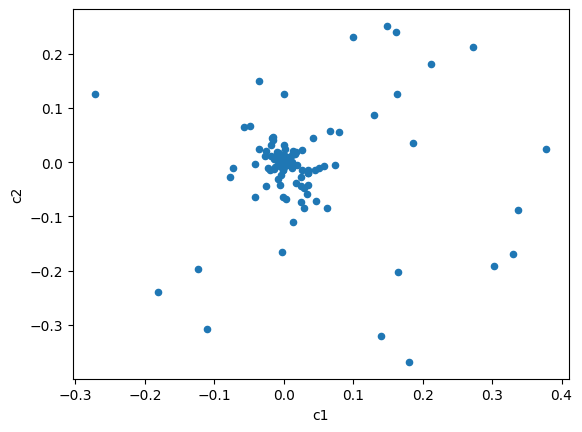

In [263]:
pd.DataFrame({'c1':pca.components_[0], 'c2':pca.components_[1]}).plot.scatter('c1', 'c2')

In [40]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [41]:
lr = LinearRegression(n_jobs=-1, fit_intercept=True)
lr.fit(training_X, np.log(training_y))
train_score = lr.score(training_X, np.log(training_y))
test_score = lr.score(test_X, np.log(test_y))

print(f'LR - TRAIN SCORE: {train_score:.2f} - TEST SCORE: {test_score:.2f}')


LR - TRAIN SCORE: 0.53 - TEST SCORE: 0.49


In [46]:
print(mean_absolute_percentage_error(training_y, np.exp(lr.predict(training_X))))
print(mean_absolute_percentage_error(test_y, np.exp(lr.predict(test_X))))

0.1425604070560701
0.12924644961970363


In [50]:
print(mean_squared_error(training_y, np.exp(lr.predict(training_X)), squared=False))
print(mean_squared_error(test_y, np.exp(lr.predict(test_X)), squared=False))

545.6124732133725
529.3467626838454


In [204]:
training_data['predicted_eur_mq'] = np.exp(lr.predict(training_X))
training_data['predicted_price'] = training_data['predicted_eur_mq'] * training_data['superficie']

mse_train = np.sqrt(np.square(training_data['euro_mq']-training_data['predicted_eur_mq']).mean())

test_data['predicted_eur_mq'] = np.exp(lr.predict(test_X))
test_data['predicted_price'] = test_data['predicted_eur_mq'] * test_data['superficie']

mse_test = np.sqrt(np.square(test_data['euro_mq']-test_data['predicted_eur_mq']).mean())

print(f'LR - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')


LR - MSE TRAIN: 545.61 - MSE TEST: 530.41


In [35]:
lr_model_dict = {}

for k, v in train_dict.items():

    lr_model_dict[k] = LinearRegression(n_jobs=-1, fit_intercept=True).fit(v['X'], np.log(v['y']))


for k, lr_mod in lr_model_dict.items():

    train_score = lr_mod.score(train_dict[k]['X'], np.log(train_dict[k]['y']))
    test_score = lr_mod.score(test_dict[k]['X'], np.log(test_dict[k]['y']))
    print(f"""{k}: TRAIN {train_score:.2f} [{train_dict[k]['X'].shape[0]}]- TEST {test_score:.2f} [{test_dict[k]['X'].shape[0]}]""")


lth_50: TRAIN 0.43 [2983]- TEST -7368015738694029132431360.00 [64]
50_100: TRAIN 0.56 [12970]- TEST -31857733990735402762240.00 [385]
l00_130: TRAIN 0.57 [5709]- TEST 0.55 [146]
gth_130: TRAIN 0.55 [3557]- TEST 0.34 [107]


In [36]:
for k, lr_mod in lr_model_dict.items():

    train_dict[k]['raw']['predicted_eur_mq'] = np.exp(lr_mod.predict(train_dict[k]['X']))
    train_dict[k]['raw']['predicted_price'] = train_dict[k]['raw']['predicted_eur_mq'] * train_dict[k]['raw']['superficie']

    mse_train = np.sqrt(np.square(train_dict[k]['raw']['euro_mq']-train_dict[k]['raw']['predicted_eur_mq']).mean())

    test_dict[k]['raw']['predicted_eur_mq'] = np.exp(lr_mod.predict(test_dict[k]['X']))
    test_dict[k]['raw']['predicted_price'] = test_dict[k]['raw']['predicted_eur_mq'] * test_dict[k]['raw']['superficie']

    mse_test = np.sqrt(np.square(test_dict[k]['raw']['euro_mq']-test_dict[k]['raw']['predicted_eur_mq']).mean())

    print(f'[{k}] - LR - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

train_raw = pd.concat([v['raw'] for k, v in train_dict.items()])
test_raw = pd.concat([v['raw'] for k, v in test_dict.items()])

mse_train = np.sqrt(np.square(train_raw['euro_mq']-train_raw['predicted_eur_mq']).mean())
mse_test = np.sqrt(np.square(test_raw['euro_mq']-test_raw['predicted_eur_mq']).mean())

print(f'LR - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

[lth_50] - LR - MSE TRAIN: 481.03 - MSE TEST: 849.31
[50_100] - LR - MSE TRAIN: 516.47 - MSE TEST: inf
[l00_130] - LR - MSE TRAIN: 489.90 - MSE TEST: 526.29
[gth_130] - LR - MSE TRAIN: 569.18 - MSE TEST: 632.18
LR - MSE TRAIN: 514.37 - MSE TEST: inf


C:\Users\matte\AppData\Local\Temp\ipykernel_13948\353620736.py:8: RuntimeWarning: overflow encountered in exp
  test_dict[k]['raw']['predicted_eur_mq'] = np.exp(lr_mod.predict(test_dict[k]['X']))


In [37]:
rf = RandomForestRegressor(n_jobs=-1,# n_estimators=50, min_samples_leaf=10,
                           criterion='squared_error')

rf.fit(training_X, training_y)

train_score = rf.score(training_X, training_y)
test_score = rf.score(test_X, test_y)

print(f'RF - TRAIN SCORE: {train_score:.2f} - TEST SCORE: {test_score:.2f}')

C:\Users\matte\AppData\Local\Temp\ipykernel_13948\2570628723.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(training_X, training_y)


RF - TRAIN SCORE: 0.95 - TEST SCORE: 0.59


In [38]:
training_data['predicted_eur_mq'] = rf.predict(training_X)
training_data['predicted_price'] = training_data['predicted_eur_mq'] * training_data['superficie']

mse_train = np.sqrt(np.square(training_data['euro_mq']-training_data['predicted_eur_mq']).mean())

test_data['predicted_eur_mq'] = rf.predict(test_X)
test_data['predicted_price'] = test_data['predicted_eur_mq'] * test_data['superficie']

mse_test = np.sqrt(np.square(test_data['euro_mq']-test_data['predicted_eur_mq']).mean())

print(f'RF - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')


RF - MSE TRAIN: 172.50 - MSE TEST: 477.69


In [265]:
xgb = XGBRegressor(n_jobs=-1, grow_policy='lossguide')
xgb.fit(training_X, np.log(training_y))

train_score = xgb.score(training_X, np.log(training_y))
test_score = xgb.score(test_X, np.log(test_y))

print(f'XGB - TRAIN SCORE: {train_score:.2f} - TEST SCORE: {test_score:.2f}')

XGB - TRAIN SCORE: 0.75 - TEST SCORE: 0.54


In [266]:
training_data['predicted_eur_mq'] = np.exp(xgb.predict(training_X))
training_data['predicted_price'] = training_data['predicted_eur_mq'] * training_data['superficie']

mse_train = np.sqrt(np.square(training_data['euro_mq']-training_data['predicted_eur_mq']).mean())

test_data['predicted_eur_mq'] = np.exp(xgb.predict(test_X))
test_data['predicted_price'] = test_data['predicted_eur_mq'] * test_data['superficie']

mse_test = np.sqrt(np.square(test_data['euro_mq']-test_data['predicted_eur_mq']).mean())

print(f'XGB - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

XGB - MSE TRAIN: 397.42 - MSE TEST: 508.56


In [267]:
xgb_model_dict = {}

for k, v in train_dict.items():

    xgb_model_dict[k] = XGBRegressor(n_jobs=-1, grow_policy='lossguide').fit(v['X'], np.log(v['y']))


for k, xgb_m in xgb_model_dict.items():

    train_score = xgb_m.score(train_dict[k]['X'], np.log(train_dict[k]['y']))
    test_score = xgb_m.score(test_dict[k]['X'], np.log(test_dict[k]['y']))
    print(f"""{k}: TRAIN {train_score:.2f} - TEST {test_score:.2f}""")


lth_50: TRAIN 0.84 - TEST 0.48
50_100: TRAIN 0.79 - TEST 0.56
l00_130: TRAIN 0.89 - TEST 0.59
gth_130: TRAIN 0.90 - TEST 0.51


In [268]:
for k, xgb_m in xgb_model_dict.items():

    train_dict[k]['raw']['predicted_eur_mq'] = np.exp(xgb_m.predict(train_dict[k]['X']))
    train_dict[k]['raw']['predicted_price'] = train_dict[k]['raw']['predicted_eur_mq'] * train_dict[k]['raw']['superficie']

    mse_train = np.sqrt(np.square(train_dict[k]['raw']['euro_mq']-train_dict[k]['raw']['predicted_eur_mq']).mean())

    test_dict[k]['raw']['predicted_eur_mq'] = np.exp(xgb_m.predict(test_dict[k]['X']))
    test_dict[k]['raw']['predicted_price'] = test_dict[k]['raw']['predicted_eur_mq'] * test_dict[k]['raw']['superficie']

    mse_test = np.sqrt(np.square(test_dict[k]['raw']['euro_mq']-test_dict[k]['raw']['predicted_eur_mq']).mean())

    print(f'[{k}] - XGB - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

train_raw = pd.concat([v['raw'] for k, v in train_dict.items()])
test_raw = pd.concat([v['raw'] for k, v in test_dict.items()])

mse_train = np.sqrt(np.square(train_raw['euro_mq']-train_raw['predicted_eur_mq']).mean())
mse_test = np.sqrt(np.square(test_raw['euro_mq']-test_raw['predicted_eur_mq']).mean())

print(f'XGB - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

[lth_50] - XGB - MSE TRAIN: 258.74 - MSE TEST: 425.27
[50_100] - XGB - MSE TRAIN: 355.87 - MSE TEST: 464.35
[l00_130] - XGB - MSE TRAIN: 249.62 - MSE TEST: 519.34
[gth_130] - XGB - MSE TRAIN: 272.83 - MSE TEST: 522.24
XGB - MSE TRAIN: 312.50 - MSE TEST: 482.09


In [269]:
for k, _ in xgb_model_dict.items():

    train_score = xgb.score(train_dict[k]['X'], np.log(train_dict[k]['y']))
    test_score = xgb.score(test_dict[k]['X'], np.log(test_dict[k]['y']))
    print(f"""{k}: TRAIN {train_score:.2f} - TEST {test_score:.2f}""")


lth_50: TRAIN 0.51 - TEST 0.35
50_100: TRAIN 0.74 - TEST 0.55
l00_130: TRAIN 0.76 - TEST 0.48
gth_130: TRAIN 0.77 - TEST 0.54


In [270]:
for k, xgb_m in xgb_model_dict.items():

    train_dict[k]['raw']['predicted_eur_mq'] = np.exp(xgb.predict(train_dict[k]['X']))
    train_dict[k]['raw']['predicted_price'] = train_dict[k]['raw']['predicted_eur_mq'] * train_dict[k]['raw']['superficie']

    mse_train = np.sqrt(np.square(train_dict[k]['raw']['euro_mq']-train_dict[k]['raw']['predicted_eur_mq']).mean())

    test_dict[k]['raw']['predicted_eur_mq'] = np.exp(xgb.predict(test_dict[k]['X']))
    test_dict[k]['raw']['predicted_price'] = test_dict[k]['raw']['predicted_eur_mq'] * test_dict[k]['raw']['superficie']

    mse_test = np.sqrt(np.square(test_dict[k]['raw']['euro_mq']-test_dict[k]['raw']['predicted_eur_mq']).mean())

    print(f'[{k}] - XGB - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

train_raw = pd.concat([v['raw'] for k, v in train_dict.items()])
test_raw = pd.concat([v['raw'] for k, v in test_dict.items()])

mse_train = np.sqrt(np.square(train_raw['euro_mq']-train_raw['predicted_eur_mq']).mean())
mse_test = np.sqrt(np.square(test_raw['euro_mq']-test_raw['predicted_eur_mq']).mean())

print(f'XGB - MSE TRAIN: {mse_train:.2f} - MSE TEST: {mse_test:.2f}')

[lth_50] - XGB - MSE TRAIN: 451.58 - MSE TEST: 479.27
[50_100] - XGB - MSE TRAIN: 397.92 - MSE TEST: 479.45
[l00_130] - XGB - MSE TRAIN: 366.48 - MSE TEST: 572.60
[gth_130] - XGB - MSE TRAIN: 401.96 - MSE TEST: 514.75
XGB - MSE TRAIN: 398.43 - MSE TEST: 505.56


## Provo la divisione per zona geografica

In [143]:
data.loc[data.zona == 'San Donato', ['zona','euro_mq']].groupby('zona').agg(['mean', 'count']).reset_index().sort_values(('euro_mq', 'mean'))

zona      euro_mq      
                      mean count
0  San Donato  2615.886006  1282

In [142]:
data.loc[data.zona == 'San Donato', ['area_statistica', 'euro_mq']].groupby('area_statistica').agg(['mean', 'count']).reset_index().sort_values(('euro_mq', 'mean'))

area_statistica      euro_mq      
                                  mean count
4                PILASTRO  2124.080116   191
0                    CAAB  2374.896554    23
5             SAN DONNINO  2427.817743   122
3               MICHELINO  2463.938061   197
6  SCALO MERCI SAN DONATO  2500.000000     1
1      CADRIANO-CALAMOSCO  2664.679491    17
8               VIA MONDO  2756.237034   413
2                   FIERA  2908.628533     6
7          VIA DEL LAVORO  2910.503706   312

In [273]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [252]:
_drop_col = ['bagni_lkp_##', 'stato_nan', 'piani_totali_lkp_-1', 
             'piano_lkp_+0', 'anno_costruzione_lkp_0_O_ANNO', 'zona_adj_ND',
             'classe_energetica_lkp_ ', 'riscaldamento_centralizzato_cat_nan', 
             'esposizione doppia_ac_feat','infissi esterni in vetro / legno_ac_feat', 
             'cancello elettrico_ac_feat', 'esposizione esterna_ac_feat', 'armadio a muro_ac_feat',
             'impianto tv singolo_ac_feat', 'mansarda_ac_feat','impianto tv con parabola satellitare_ac_feat', 
             'idromassaggio_ac_feat', 'reception_ac_feat', 'cucina_ac_feat', 'canna fumaria_ac_feat']

In [279]:
pol = PolynomialFeatures(interaction_only=True, include_bias=False)
pca = PCA(n_components=50)
pol_data = pol.fit_transform(training_X)
pca_data = pca.fit_transform(pol_data)

In [287]:
pd.DataFrame(pol_data).corr()

In [281]:
results = sm.OLS(training_y, pca_data).fit()

In [283]:
# Adj. R-squared: 0.529
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                euro_mq   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              8.839
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                    1.78e-63
Time:                        23:14:32   Log-Likelihood:                     -2.2714e+05
No. Observations:               23913   AIC:                                  4.544e+05
Df Residuals:                   23863   BIC:                                  4.548e+05
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [149]:
data.join(test_data[['predicted_eur_mq', 'predicted_price']], how='inner').to_excel('test_data_zona_pca.xlsx')